---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: false
---

# Building our random forest model

Now that we have loaded and processed our data, we will proceed to build and test our random forest model.


In [72]:
!pip install statsmodels

# load necessary libraries
import os
import requests
import pysal
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import osmnx as ox
import statsmodels.api as sm
from census import Census
from us import states
from folium import plugins
from sklearn.preprocessing import QuantileTransformer
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

In [3]:
# load processed data
geo_data = gpd.read_file("geo_data_crashes.geojson")

## Model design

Because the goal of this project is to predict future non-motorist crashes, we need to show how well our model can perform on existing data where we can verify predictions with observed data. Therefore, we will predict 2023 crashes using data from the prior five years - 2018 through 2022.

### Preparing the predictors

Along with our crash count columms, we select variables associated with commuting patterns, vehicle ownership, and road characteristics.

#### Commuting patterns

#### Vehicle ownership

#### Road characteristics


In [71]:
# Step 1: Prepare the data
# Select columns that start with "crash_", "commute_", "vehicle_", end with "_proportion", and "total_length"
predictor_columns = [col for col in geo_data.columns if col.startswith("crash_") or col.startswith("commute_") or col.startswith("vehicle_") or col.endswith("_proportion") or col == "total_length"]

# Ensure the target variable for 2023 is included
target_column = "crash_2023"

# Filter the data to include only the selected columns and the target variable
data = geo_data[predictor_columns + [target_column]]

# Drop rows with missing values
data = data.dropna()

# Step 2: Split the data into training and testing sets
# Use data from 2018 through 2022 for training
train_columns = [col for col in predictor_columns if col.startswith("crash_2018") or col.startswith("crash_2019") or col.startswith("crash_2020") or col.startswith("crash_2021") or col.startswith("crash_2022") or col.startswith("commute_") or col.startswith("vehicle_") or col.endswith("_proportion") or col == "total_length"]



/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.7623932291666667
Feature Importances:
crash_2020                  0.197506
crash_2019                  0.192598
crash_2022                  0.185176
crash_2018                  0.085692
crash_2021                  0.060532
commute_carpool             0.038589
commute_public_transport    0.034651
residential_proportion      0.031485
tertiary_proportion         0.028916
total_length                0.023906
commute_work_from_home      0.023316
commute_drive_alone         0.022898
vehicle_none                0.021817
vehicle_one                 0.021331
commute_walked              0.018153
commute_bike                0.013435
dtype: float64


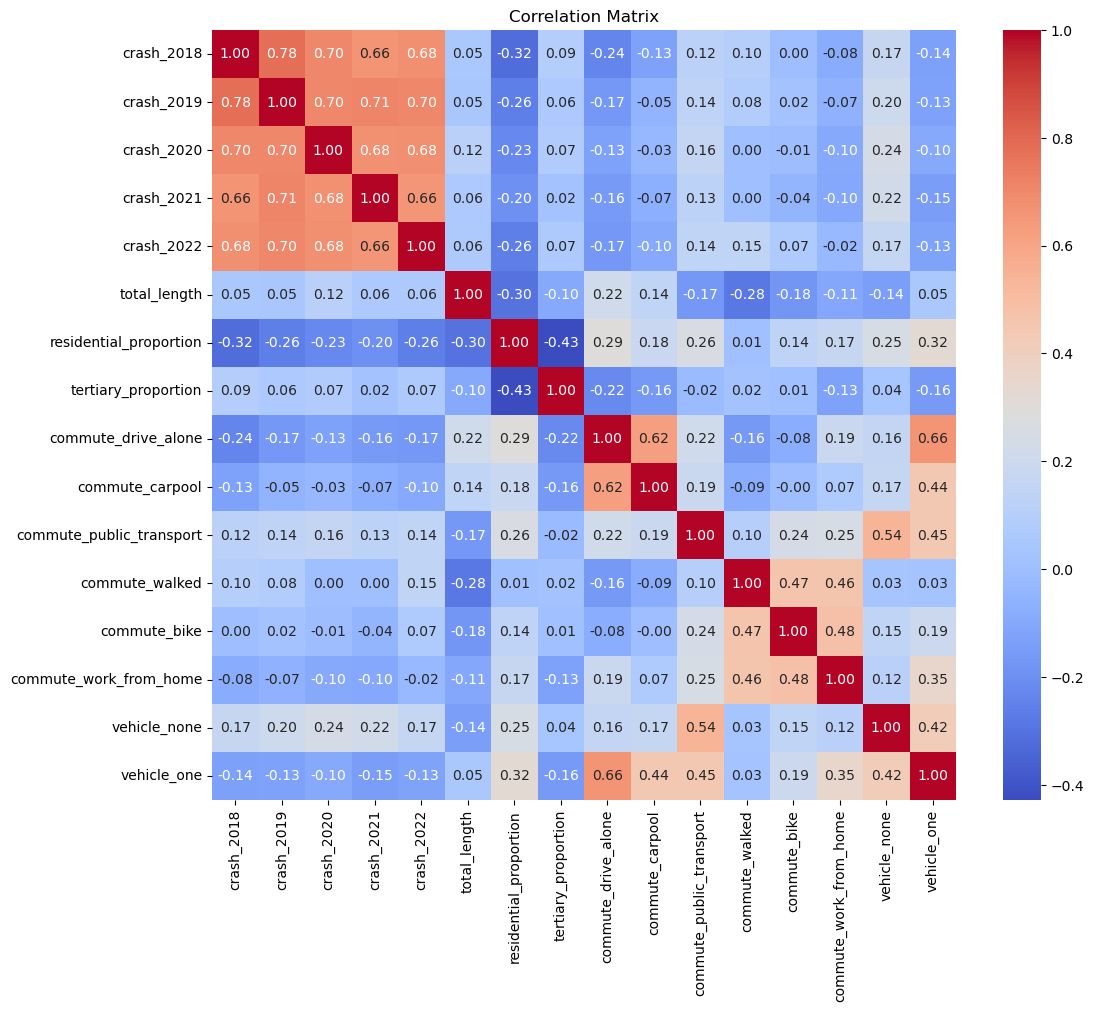

In [73]:
# Filter the data to include only the selected columns
corr_data = geo_data[train_columns]

# Compute the correlation matrix
correlation_matrix = corr_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [62]:

X_train = data[train_columns]
y_train = data[target_column]
X_test = data[train_columns]
y_test = data[target_column]

y_train = y_train.loc[:, ~y_train.columns.duplicated()]
y_test = y_test.loc[:, ~y_test.columns.duplicated()]

# set up random forest pipeline
forest = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# generate hyperparameter grid
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

# create grid and use 3-fold CV
grid = GridSearchCV(forest, param_grid, cv=3, verbose=1)

# run the model
grid.fit(X_train, y_train)

# display optimized hyperparameters
grid.best_params_

# show score
grid.score(X_test, y_test)

# show feature importance
feature_importances = pd.Series(model.feature_importances_, index=train_columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1

0.8008675899199459

In [67]:
# evaluate the best random forest model
best_random = grid.best_estimator_

# make the predictions
predictions = best_random.predict(X_test)

# absolute error
y_test_array = y_test.values.flatten()

errors = abs(predictions - y_test_array)
avg_error = np.mean(errors)

poisson_deviance = mean_poisson_deviance(y_test_array, predictions)

print("Model Performance")
print(f"Average Absolute Error: {avg_error:0.4f}")
print("We do not report MAPE because of zero values in the observed data")
print(f"Poisson Deviance: {poisson_deviance}")

Model Performance
Average Absolute Error: 1.1078
We do not report MAPE because of zero values in the observed data
Poisson Deviance: 0.8103405863276233


In [68]:
# Prepare the data
# Assuming X_train, y_train, X_test, y_test are already defined

# Add a constant to the predictors (intercept term)
X_train_nb = sm.add_constant(X_train)
X_test_nb = sm.add_constant(X_test)

# Fit the Poisson regression model
nb_model = sm.GLM(y_train, X_train_nb, family=sm.families.NegativeBinomial()).fit()

# Make predictions
nb_predictions = nb_model.predict(X_test_nb)

# Calculate the absolute errors
nb_errors = abs(nb_predictions - y_test_array)

# Calculate the average error
nb_avg_error = np.mean(nb_errors)

# Mean absolute percentage error
nb_mape = 100 * np.mean(nb_errors / y_test_array)

# Calculate the Poisson deviance
nb_poisson_deviance = mean_poisson_deviance(y_test_array, nb_predictions)


print("Negative binomial regression model performance")
print(f"Average absolute error: {nb_avg_error:0.4f}")
print("We do not report MAPE because of zero values in the observed data")
print(f"Poisson Deviance: {nb_poisson_deviance}")

Negative binomial regression model performance
Average absolute error: 2.0724
We do not report MAPE because of zero values in the observed data
Poisson Deviance: 1.9579885952071716


/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


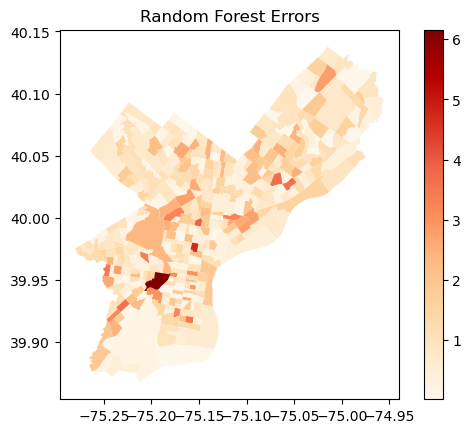

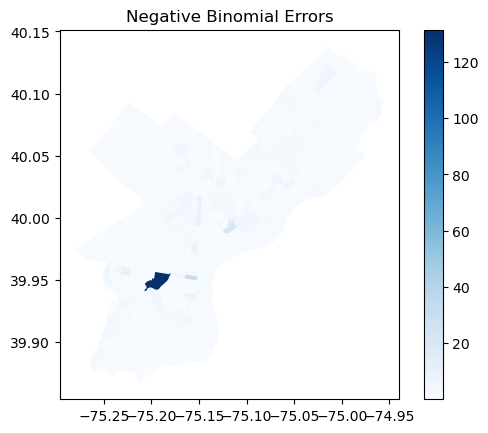

In [65]:
# Add errors to geo_data
geo_data['rf_errors'] = errors

# Add nb_errors to geo_data
geo_data['nb_errors'] = nb_errors

# Plot the map for random forest errors
geo_data.plot(column='rf_errors', legend=True, cmap='OrRd')
plt.title('Random Forest Errors')
plt.show()

# Plot the map for negative binomial errors
geo_data.plot(column='nb_errors', legend=True, cmap='Blues')
plt.title('Negative Binomial Errors')
plt.show()